In [1]:
using Agents
using Graphs
using DynamicalSystems
using InteractiveDynamics
using GLMakie
using CairoMakie
using GraphMakie
using Karnak
using NetworkLayout
using Plots
using StatsPlots

using Random
using Measures
using Compose, Cairo, Fontconfig
using Colors

### Create Graph Space

In [2]:
SEED = 123

123

In [3]:
# set up the dims of grid
const NN = 13
const GRID_DIM = (NN,NN)

# agent num = 75% of the node
TOTAL_AGENTS = round( Int, 0.75*prod(GRID_DIM) );

# make a lattice grid graph space
residential_graph = Graphs.grid( GRID_DIM, periodic=false )

{169, 312} undirected simple Int64 graph

Generate a graph residential_graph, and for each node in the graph, it is randomly deciding whether to add or remove edges based on the specified THRESHOLD_RAND_ALTER probability. This code simulates the dynamic alteration of edges in the graph, possibly representing changes in connectivity or relationships between nodes.

In [4]:
# mutate the graph to have more or less edges than before
THRESHOLD_RAND_EDGE_ADD = 0.2
THRESHOLD_RAND_EDGE_RM = 0.2

for source_node in vertices(residential_graph)
    
    # add edge
    if( rand() < THRESHOLD_RAND_EDGE_ADD )
        destination_node = rand( 1:nv(residential_graph), 1)[1]
        
        if( destination_node != source_node )
            add_edge!(residential_graph, source_node, destination_node)
        end
    end
    
    # remove edge
    if( rand() < THRESHOLD_RAND_EDGE_RM )
        neighbors = all_neighbors(residential_graph, source_node)

        if( length(neighbors) > 0 )
            neighbor = rand( neighbors, 1)[1]
            rem_edge!(residential_graph, source_node, neighbor)
        end
    end
    
end
residential_graph

{169, 313} undirected simple Int64 graph

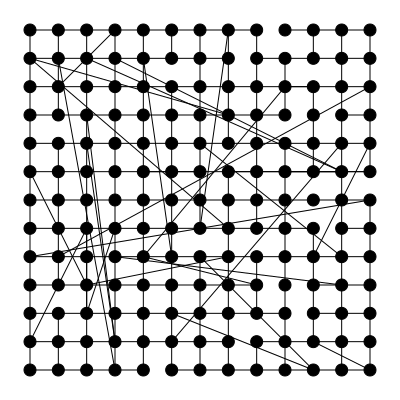

In [5]:
@drawsvg begin
    background("white")
    drawgraph(residential_graph, layout=squaregrid)
end 400 400

### Set up model

In [6]:
@agent GraphSchellingAgent GraphAgent begin
    remain::Bool
    group::Int
end

In [7]:
# @agent House GraphSchellingAgent begin
#     energy::Float64
#     reproduction_prob::Float64
#     Δenergy::Float64
# end

# @agent Wolf GridAgent{2} begin
#     energy::Float64
#     reproduction_prob::Float64
#     Δenergy::Float64
# end

In [8]:
model_iteration = 0;

In [9]:
function initialize()
    
    global model_iteration = 0
    
    space = GraphSpace( residential_graph )
    
    properties = Dict( :min_remain_percentage => 0.5 )
    rng = Random.Xoshiro(SEED)
    
    model = UnremovableABM(GraphSchellingAgent, space; properties, 
                            rng=Random.Xoshiro(SEED), scheduler=Schedulers.Randomly() )
    
    # populate the model with agents, adding equal amount of the two types of agents at random positions in the model
    for agent_ind in 1:TOTAL_AGENTS
        remain_temp = false
        group_temp = agent_ind < TOTAL_AGENTS/2 ? 1 : 2
        new_position = random_empty(model)
        
        agent_temp = GraphSchellingAgent(agent_ind, new_position, remain_temp, group_temp)
        add_agent!(agent_temp, model)
    end
    return model
end

initialize (generic function with 1 method)

In [10]:
model = initialize()

UnremovableABM with 127 agents of type GraphSchellingAgent
 space: GraphSpace with 169 positions and 313 edges
 scheduler: Agents.Schedulers.Randomly
 properties: min_remain_percentage

### Agent Steps

In [11]:
function GetAgentNeighborStatus(agent,model)
    count_near = 0
    for pos in nearby_positions( agent.pos, model,1)
        count_near += 1
    end
    
    count_neighbors_same_group = 0    
    for neighbor in nearby_agents( agent, model )
        if agent.group == neighbor.group
            count_neighbors_same_group += 1
        end
    end
    return [count_near, count_neighbors_same_group]
end
    
    
function GetAgentRemainStatus(agent, model, count_near, count_neighbors_same_group)
        
    if( (count_neighbors_same_group / count_near) <= model.min_remain_percentage )
        return false
    else
        return true
    end
end

GetAgentRemainStatus (generic function with 1 method)

In [12]:
function agent_step!(agent, model)

    count_near, count_neighbors_same_group = GetAgentNeighborStatus(agent, model)
    
    agent.remain = GetAgentRemainStatus(agent, model, count_near, count_neighbors_same_group)

    if agent.remain == false
        #move to random position
        move_agent_single!(agent, model)
        
    end
end

agent_step! (generic function with 1 method)

In [13]:
function model_step!(model)
     global model_iteration += 1 
end

model_step! (generic function with 1 method)

### Caculate Entropy

H(x)=−p(x)ln(p(x))

https://chat.openai.com/share/2f8b5ccf-beee-4bbc-a036-61b9b58245e1

In [14]:
# Get the % of agent stay in their pos
function ModelRemainTrajectory(model)
    remain = 0
    for agent in allagents(model)
        remain += agent.remain 
    end
    return remain / nagents(model)
end

# Caculate graph entropy (Micro) based on agent's group homogeneity

function GraphBaseEntropy(model)
    
    edge_total_num = 0
    agent_degree_distribution = Dict()
        
    for agent in allagents(model)
        edge_num = 0
        
        for near_agent in nearby_agents(agent,model, 1)
           if near_agent.group == agent.group
               edge_num += 1 
            end           
        end
        
        edge_total_num += edge_num
        
        if edge_num in keys(agent_degree_distribution)
            agent_degree_distribution[edge_num] += 1
        else
            agent_degree_distribution[edge_num] = 1
        end    
    end
    
    # Get agent_degree_distribution prob
    for k in keys(agent_degree_distribution)
        agent_degree_distribution[k] /= edge_total_num
    end
    
    #println(agent_degree_distribution)
    H = 0
    
     for k in keys(agent_degree_distribution)
        H += (-1) * agent_degree_distribution[k] * log(agent_degree_distribution[k])
        
    end
    
    return H
end

# Caculate graph entropy(Macro) based on node's connection

function GraphSpaceEntropy(model)
    G = model.space.graph

    node_total_num = nv(G)
    node_dregree_distrubution = Dict()
    
    for v in vertices(G)
        edge_num = length(collect(neighbors(G, v)))
        if edge_num in keys(node_dregree_distrubution)
            node_dregree_distrubution[edge_num] += 1
        else
            node_dregree_distrubution[edge_num] = 1
        end  
    end
    
    for k in keys(node_dregree_distrubution)
        node_dregree_distrubution[k] /= node_total_num
    end
    
    #println(node_dregree_distrubution)
    H = 0
    
    for k in keys(node_dregree_distrubution)
        H += (-1) * node_dregree_distrubution[k] * log(node_dregree_distrubution[k])       
    end

    return H

end


GraphSpaceEntropy (generic function with 1 method)

### Run Model

In [15]:
model = initialize()

mdata = [ModelRemainTrajectory, GraphBaseEntropy, GraphSpaceEntropy]

step_num = 100

 _, model_df = run!(model, agent_step!, step_num; mdata)

(0×0 DataFrame, 101×4 DataFrame
 Row │ step   ModelRemainTrajectory  GraphBaseEntropy  GraphSpaceEntropy 
     │ Int64  Float64                Float64           Float64           
─────┼───────────────────────────────────────────────────────────────────
   1 │     0               0.0               1.28139              1.3873
   2 │     1               0.370079          1.10879              1.3873
   3 │     2               0.566929          1.05551              1.3873
   4 │     3               0.582677          1.08841              1.3873
   5 │     4               0.582677          1.13434              1.3873
   6 │     5               0.574803          1.0783               1.3873
   7 │     6               0.637795          1.06995              1.3873
   8 │     7               0.645669          1.05462              1.3873
   9 │     8               0.653543          1.07212              1.3873
  10 │     9               0.653543          1.05289              1.3873
  11 │    10    

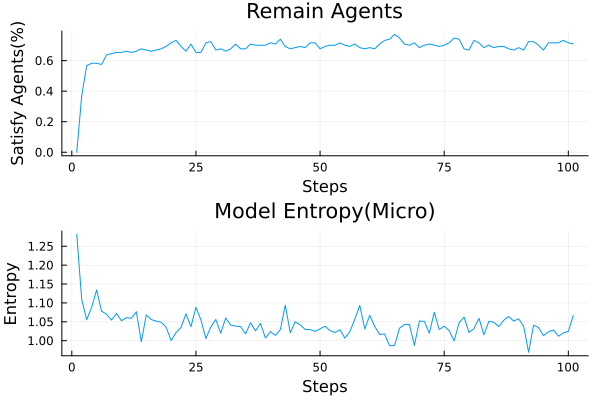

In [46]:
p1 = Plots.plot(model_df[:,:ModelRemainTrajectory], xlabel = "Steps",ylabel = "Satisfy Agents(%)",legend=false, title="Remain Agents")
p2 = Plots.plot(model_df[:,:GraphBaseEntropy], xlabel = "Steps",ylabel = "Entropy",legend=false, title="Model Entropy(Micro)")

pOveral = Plots.plot([p1,p2]..., layout=Plots.grid(2,1) )
# savefig(pOveral,"./plots4/pOverall.pdf")
display(pOveral)

### Color node based on group

In [18]:
function VertexFillColors(graph, model)    
    vertex_colors = [ RGB(0, 0, 0) for i in 1:nv(graph) ]
    
    for agent in model.agents
        
        if( agent.group == 1 )
            vertex_colors[ agent.pos ] = RGB(1, 0.65, 0)
        else 
            vertex_colors[ agent.pos ] = RGB(0, 0, 1)
        end        
    end
    
    return vertex_colors
end

VertexFillColors (generic function with 1 method)

In [19]:
# Shape: Square means satisfy, circle means not

function VertexShape(graph, model)    
    vertex_shape = [:circle for i in 1:nv(graph)]
    
    for agent in model.agents
        
        if( agent.remain==true)
            vertex_shape[ agent.pos ] = :square
        else 
            vertex_shape[ agent.pos ] = :circle
        end        
    end
    
    return vertex_shape
end

VertexShape (generic function with 1 method)

### Visualize Graph after Steps

In [38]:
values_to_select = [0, 25, 50, 75, 100]
selected_rows = filter(row -> row.step in values_to_select, model_df)

Row,step,ModelRemainTrajectory,GraphBaseEntropy,GraphSpaceEntropy
,Int64,Float64,Float64,Float64
1,0,0.0,1.28139,1.3873
2,25,0.653543,1.05538,1.3873
3,50,0.692913,1.03817,1.3873
4,75,0.716535,1.02659,1.3873
5,100,0.708661,1.06716,1.3873


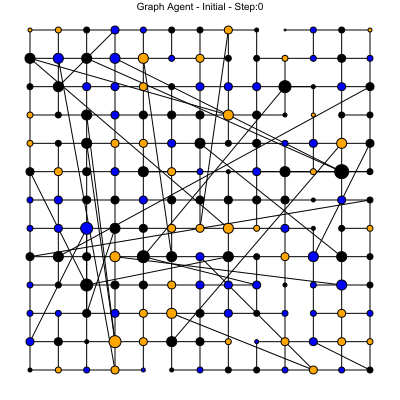

In [47]:
model_init = initialize()

g0 = @drawsvg begin
    background("white")
    drawgraph(residential_graph, 
        layout=squaregrid,
        vertexshapes = VertexShape(residential_graph, model_init),
        vertexshapesizes = [Graphs.outdegree(residential_graph, v) for v in Graphs.vertices(residential_graph)],
        vertexfillcolors = VertexFillColors(residential_graph, model_init) )
    Karnak.text( "Graph Agent - Initial - Step:0", boxtopcenter() + (0, 10), halign=:center)
end 400 400

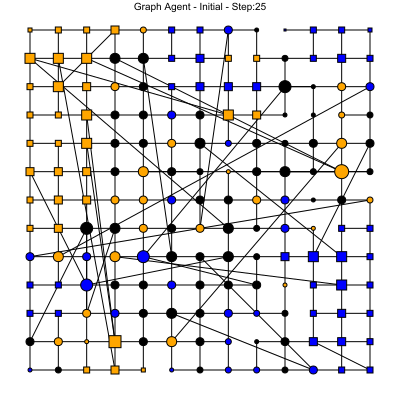

In [48]:
model = initialize()
step!(model, agent_step!, 25)
g2 = @drawsvg begin
    background("white")
    drawgraph(residential_graph, 
        layout=squaregrid,
        vertexshapes = VertexShape(residential_graph, model),
        vertexshapesizes = [Graphs.outdegree(residential_graph, v) for v in Graphs.vertices(residential_graph)],
        vertexfillcolors = VertexFillColors(residential_graph, model) )
    Karnak.text( "Graph Agent - Initial - Step:25", boxtopcenter() + (0, 10), halign=:center)
end 400 400

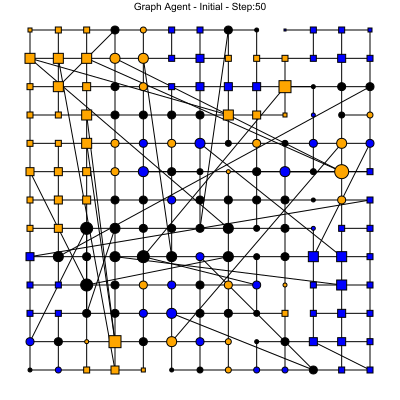

In [49]:
model = initialize()
step!(model, agent_step!, 50)
g3 = @drawsvg begin
    background("white")
    drawgraph(residential_graph, 
        layout=squaregrid,
        vertexshapes = VertexShape(residential_graph, model),
        vertexshapesizes = [Graphs.outdegree(residential_graph, v) for v in Graphs.vertices(residential_graph)],
        vertexfillcolors = VertexFillColors(residential_graph, model) )
    Karnak.text( "Graph Agent - Initial - Step:50", boxtopcenter() + (0, 10), halign=:center)
end 400 400

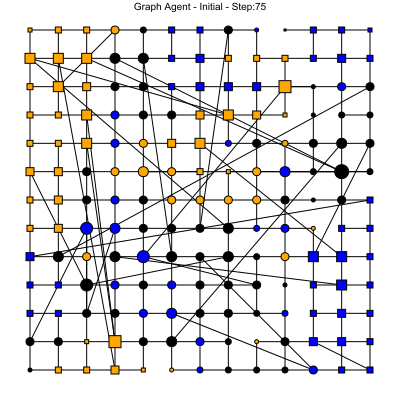

In [50]:
model = initialize()
step!(model, agent_step!, 75)
g4 = @drawsvg begin
    background("white")
    drawgraph(residential_graph, 
        layout=squaregrid,
        vertexshapes = VertexShape(residential_graph, model),
        vertexshapesizes = [Graphs.outdegree(residential_graph, v) for v in Graphs.vertices(residential_graph)],
        vertexfillcolors = VertexFillColors(residential_graph, model) )
    Karnak.text( "Graph Agent - Initial - Step:75", boxtopcenter() + (0, 10), halign=:center)
end 400 400

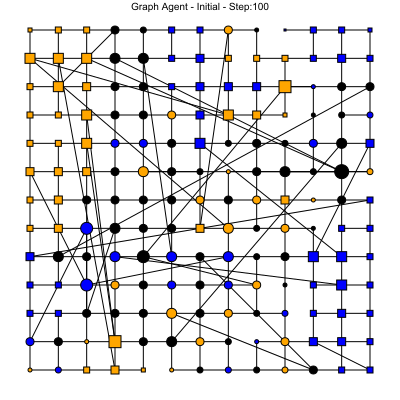

In [51]:
model = initialize()
step!(model, agent_step!, 100)
g5 = @drawsvg begin
    background("white")
    drawgraph(residential_graph, 
        layout=squaregrid,
        vertexshapes = VertexShape(residential_graph, model),
        vertexshapesizes = [Graphs.outdegree(residential_graph, v) for v in Graphs.vertices(residential_graph)],
        vertexfillcolors = VertexFillColors(residential_graph, model) )
    Karnak.text( "Graph Agent - Initial - Step:100", boxtopcenter() + (0, 10), halign=:center)
end 400 400

In [58]:
using Interact, Colors, Luxor
@manipulate for h in 0:360, s in 0:0.01:1, b in 0:0.01:1
    d = Drawing(300, 300, :svg)
    sethue(Colors.HSB(h, s, b))
    origin()
    circle(Point(0, 0), 100, action = :fill)  
    circle(polar(110, deg2rad(h)), 10, action = :fill)
    sethue("black")
    label(string(h, "°"), deg2rad(h), polar(120, deg2rad(h)))
        finish()
    d
end

WebIO._IJuliaInit()

LoadError: ArgumentError: Package Luxor not found in current path, maybe you meant `import/using .Luxor`.
- Otherwise, run `import Pkg; Pkg.add("Luxor")` to install the Luxor package.

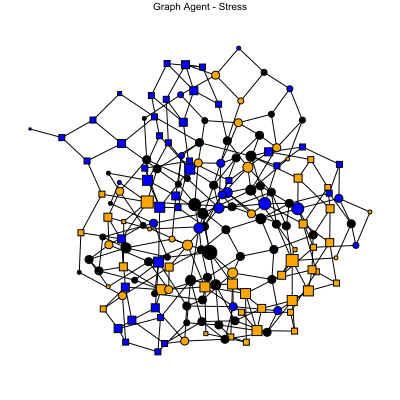

In [29]:
@drawsvg begin
    background("white")
    drawgraph(residential_graph, 
        layout=stress,
        vertexshapes = VertexShape(residential_graph, model),
        vertexshapesizes = [Graphs.outdegree(residential_graph, v) for v in Graphs.vertices(residential_graph)],
        vertexfillcolors = VertexFillColors(residential_graph, model) )
    Karnak.text( "Graph Agent - Stress", boxtopcenter() + (0, 10), halign=:center)
end 400 400

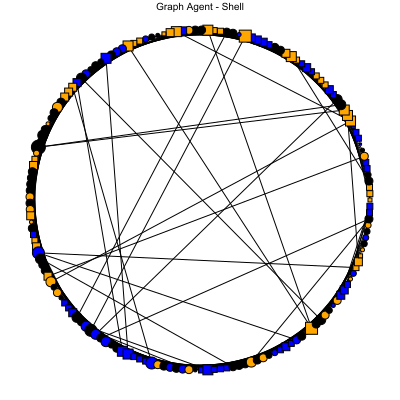

In [30]:
@drawsvg begin
    background("white")
    drawgraph(residential_graph, 
        vertexshapes = VertexShape(residential_graph, model),
        vertexshapesizes = [Graphs.outdegree(residential_graph, v) for v in Graphs.vertices(residential_graph)],
        layout=shell, 
        vertexfillcolors = VertexFillColors(residential_graph, model) )
    Karnak.text( "Graph Agent - Shell", boxtopcenter() + (0, 10), halign=:center)
end 400 400

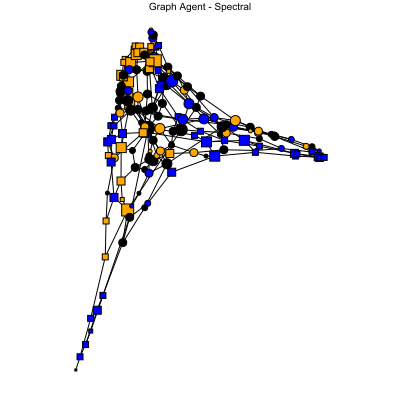

In [31]:
@drawsvg begin
    background("white")
    drawgraph(residential_graph, 
        vertexshapes = VertexShape(residential_graph, model),
        vertexshapesizes = [Graphs.outdegree(residential_graph, v) for v in Graphs.vertices(residential_graph)],
        layout=(g) -> spectral(adjacency_matrix(g), dim=2), 
        vertexfillcolors = VertexFillColors(residential_graph, model) )
    Karnak.text( "Graph Agent - Spectral", boxtopcenter() + (0, 10), halign=:center)
end 400 400

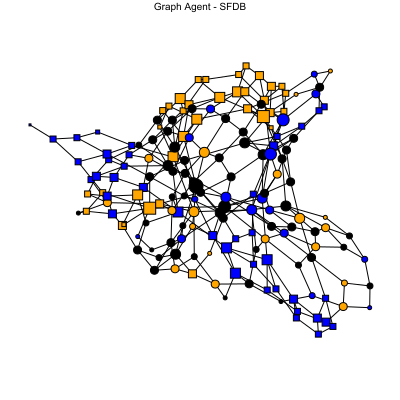

In [32]:
@drawsvg begin
    background("white")
    drawgraph(residential_graph, 
        layout=(g) -> sfdp(residential_graph, Ptype=Float64, dim=2, tol=0.05, C=0.4, K=2),
        vertexshapes = VertexShape(residential_graph, model),
        vertexshapesizes = [Graphs.outdegree(residential_graph, v) for v in Graphs.vertices(residential_graph)],
        vertexfillcolors = VertexFillColors(residential_graph, model) )
    Karnak.text( "Graph Agent - SFDB", boxtopcenter() + (0, 10), halign=:center)
end 400 400

In [34]:
model = initialize()

adata = [ :remain, :group]

step_num = 1000
agent_df= run!(model, agent_step!, step_num; adata)

(127127×4 DataFrame
    Row │ step   id     remain  group 
        │ Int64  Int64  Bool    Int64 
────────┼─────────────────────────────
      1 │     0      1   false      1
      2 │     0      2   false      1
      3 │     0      3   false      1
      4 │     0      4   false      1
      5 │     0      5   false      1
      6 │     0      6   false      1
      7 │     0      7   false      1
      8 │     0      8   false      1
      9 │     0      9   false      1
     10 │     0     10   false      1
     11 │     0     11   false      1
   ⋮    │   ⋮      ⋮      ⋮       ⋮
 127118 │  1000    118    true      2
 127119 │  1000    119    true      2
 127120 │  1000    120    true      2
 127121 │  1000    121   false      2
 127122 │  1000    122    true      2
 127123 │  1000    123    true      2
 127124 │  1000    124    true      2
 127125 │  1000    125    true      2
 127126 │  1000    126    true      2
 127127 │  1000    127    true      2
                   127106 row